# Analysis of the Proxy-NCA Challenge

In this Notebook, I will discuss my solution to the Proxy-NCA challenge. 

Section 1 of the notebook summarizes the results. The other sections are there for more fine-grained information, if you want it. 

Section 2 describes the testing in more detail and shows graphs of the results in each category. 

Section 3 contains all of the theoretical new information, I learned during this challenge. 


The notebook is designed to be used together with the table of contents nbextension for jupyter notebook. This allows the user to easily jump from the summary section to another section they are interested in.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1 Summary of Results

This section will be a short overview over the results and the answers to the questions. A more in-depth analysis will be provided in further sections.

### 1.1 Learnings During Training

In the first part of the challenge, I trained and analyzed models based on the [Pytorch implementation](https://github.com/dichotomies/proxy-nca) of [No Fuss Distance Metric Learning using Proxies](https://arxiv.org/abs/1703.07464) on the [UPMC Food-101 dataset](http://visiir.lip6.fr), which contains images and recipes of 101 classes of food.

#### 1.1.1 Theoretical Background
* A summary of the theoretical background of the method can be found in section 3.1.1.2 of this notebook

#### 1.1.2 Pytorch Implementation
* The model shows inconsistent performance depending on the Pytorch version used (sec.2.4).
* The implementation does not fully seed cudnn. This leads to issues with reproducibility. This slight issue can be fixed easily by adding the lines:

 `torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False`
 
  at the beginning of the seeding process.
 
#### 1.1.3 Proxy-NCA Learning
* The model's performance can be impacted quite significantly by its initial parameters in certain cases (sec 2.1)

#### 1.1.4 Proxy-NCA applied to the Food-101 dataset
* To use the model to train on the Food-101 dataset, I used the pre-defined cub pipeline with minor changes, since this dataset has a very similar 
* The model converges very quickly. Typically achieving the best results in both recall@k and NBI after about 5 training epochs


* Don't use current PyTorch version! Trained model will perform worse than the initial model. Used 1.1.0, since it was the minimum version mentioned in the github
* Models converged very quickly and performed best (recall @ k) at around 5 training epochs, then degraded in this metric
* Euclidean distance is used
* The method is highly influenced by the original state of the proxy matrix (see grid-search)
* Zero-shot learning
* 

### 1.2 Incorporating Unlabeled Data into Proxy-Learning

Proxy-NCA learning is designed with unlabeled data in mind. The model has two modes of assigning data points to proxies. The static and the dynamic mode. The static mode is used with labeled data, whereas the dynamic mode is used with unlabeled data. Broadly speaking, the static mode assigns the proxies to classes and uses the proxy of a data point's class to represent that datapoint. The dynamic mode represents each data point by the closest proxy. The modes are discussed in more detail in sec. 3.1.1.2. This means that if the labeled data consists of the same classes as those labeled in the training set, meaning, there are no distractor classes, the native solution can just be used.



When incorporating unlabeled data into proxy-nca training. The data can be added to the general pool of training data.

The assignment of this data to proxies is then done using the "dynamic" assignment mode

Proxies are constructed randomly, whereas prototypes in prototypical networks are constructed as means of each class. The number of prototypes is the same as the number of classes used in training. The number of proxies can be any fraction or multiple of the number of classes. In the Pytorch implementation, though, it is set to 1. These are the main differences between the two, meaning, the same procedures could be used on both:

* If the classes in the unlabeled data are assumed to be the same as those of the training set, the datapoints could just be added into the dataset during training. The sampled point would then have to assigned to a class. The proxies are not necessarily bound to 

The process in which prototypes are constructed in a prototypical network is very similar to the process of creating proxies. For this reason using unlabeled data could be done in an analogous way when computing proxies

## 2. In-Depth Analysis of model performance

During my training and testing of the model, I did a full

In [2]:
class args():
    dataset = 'cub'

In [3]:
def plot_df(data, labels = 'all', title = 'your ad here', colors = 'all'):
    if type(data) != list:
        data = [data]
        color_a = np.array(['b','g','r','m','y','c','k','tomato','darkorange','navy','lime','pink','gold','brown','slateblue','goldenrod'])
    else:
        color_a = np.array(['b','g','r','purple','y','c','k',
                             'navy','lime','pink','m','gold','cyan','dimgrey'])
    fig = plt.figure(figsize = (17,13)) 
    fig.suptitle( title, fontsize = 25)
    gs = fig.add_gridspec(3,2)
    gs.update(wspace = 0.2, hspace = 0.2)

    f_ax1 = fig.add_subplot(gs[0,0])
    f_ax2 = fig.add_subplot(gs[0,1])
    f_ax3 = fig.add_subplot(gs[1,0])
    f_ax4 = fig.add_subplot(gs[1,1], sharex = f_ax2) 
    f_ax5 = fig.add_subplot(gs[2,:])

    axs = [f_ax1, f_ax2, f_ax3, f_ax4, f_ax5]
    subtitles = ['Recall@1', 'Recall@2', 'Recall@4', 'Recall@8', 'Normalized Mutual Information']
    ax_titles = ['r@1', 'r@2', 'r@4', 'r@8', 'NMI']
    for ax_ind in range(len(axs)):
#         axs[ax_ind].set_title(subtitles[ax_ind], fontsize = 18, pad = 12)
        if ax_ind > 1:
            axs[ax_ind].set_xlabel('Epochs', fontsize = 15)
        axs[ax_ind].set_ylabel(ax_titles[ax_ind], fontsize = 15)
    color_ind_base = 0
    for results_df1 in data:
        color_ind = color_ind_base
        for i in results_df1['index'].unique():
            df = results_df1[results_df1['index']==i]
            # Label dictionary
            lbls = {}
            lbls['all'] = f'''lr:{df.lr.unique()[0]},scl_x:{df.scl_x.unique()[0]},scl_p:{df.scl_p.unique()[0]},
            sz_emb:{df.sz_emb.unique()[0]}, seed:{df.seed.unique()[0]}'''
            lbls['seed'] = f'seed:{df.seed.unique()[0]}'
            lbls['lr'] = f'lr:{df.lr.unique()[0]}'
            lbls['ed'] = f'ed:{df.edition.unique()[0]}'
            lbls['batch'] = f'batch:{df.batch.unique()[0]}'
            if type(labels) == str:
                if labels in lbls.keys():
                    lbl = lbls[labels]
                else: lbl = labels
            elif type(labels) == list:
                for lbl_ind in range(len(labels)):
                    if lbl_ind == 0:
                        label = lbls[labels[lbl_ind]]
                    else:
                        label = f'{label}, {lbls[labels[lbl_ind]]}'
                lbl = label
            
            
            for ax_ind_plot in range(len(axs)):
                if colors == 'all':
                    col_line = color_a[color_ind]
                else:
                    col_line = colors[int(color_ind_base/7)]
                axs[ax_ind_plot].plot(df.epoch, df[ax_titles[ax_ind_plot]], label = lbl, c = col_line)
                
            color_ind += 1
        color_ind_base += 7
    plt.setp(f_ax2.get_xticklabels(), visible=False)
    plt.setp(f_ax1.get_xticklabels(), visible=False)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.show()


In [12]:
food_df = pd.read_csv('food-results.csv')
cub_df = pd.read_csv(f'cub-results.csv')

### 2.1 Impact of Starting Meta-Parameters on model performance

During the evaluation of the impact of different model parameters on the model's performance, some inconsistencies arose. The model would react differently to the same change in parameters and re-running a model using the same parameters would in some cases yield wildly different performance results.

For this reason, I tested the model's sensitivity to changes in the initial parameters. I used different random seeds to train and test models, while keeping all other model parameters the same. The results can be seen below:

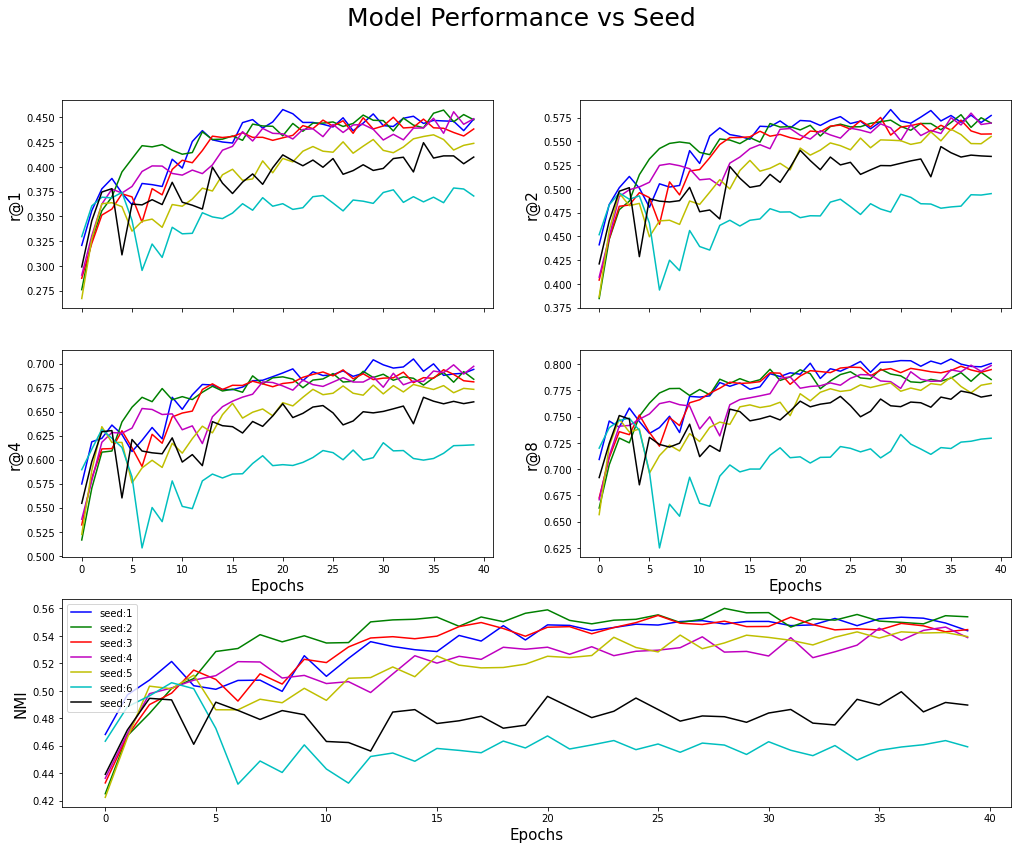

In [5]:
cub_seed_df = cub_df[(cub_df['index'] >= 29) & (cub_df['index'] <= 35)]
plot_df(cub_seed_df, labels = 'seed', title = 'Model Performance vs Seed')

### 2.2 Impact of Batch Size on Model Performance

(760, 15)
(695, 15)


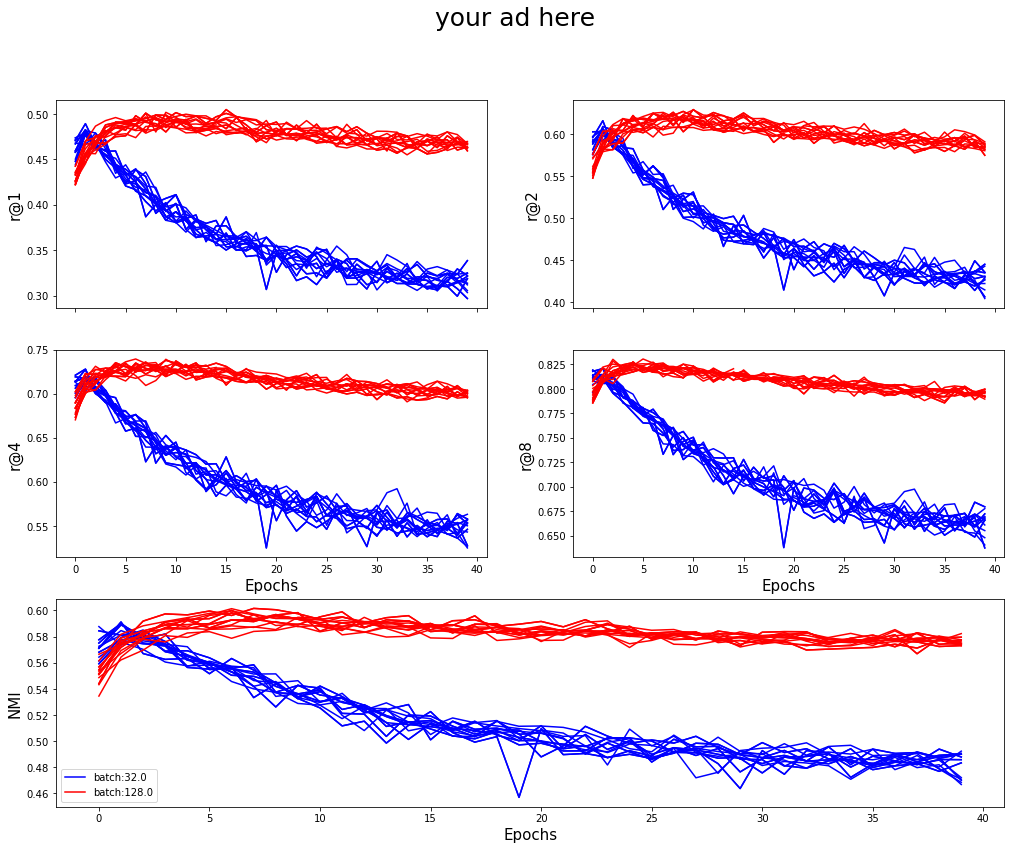

In [6]:
batch_df = cub_df[(cub_df.scl_x ==1) & (cub_df.scl_p == 1) & (cub_df.lr == 1) & 
       (cub_df.batch == 32)]
batch_df1 = cub_df[(cub_df.scl_x ==1) & (cub_df.scl_p == 1) & (cub_df.lr == 1) & 
       (cub_df.batch == 128) & (cub_df['torch version'] == '1.1.0')]
print(batch_df.shape)
print(batch_df1.shape)
plot_df([batch_df,batch_df1], labels = 'batch', colors = ['b','r'])

(40, 15)
(125, 15)


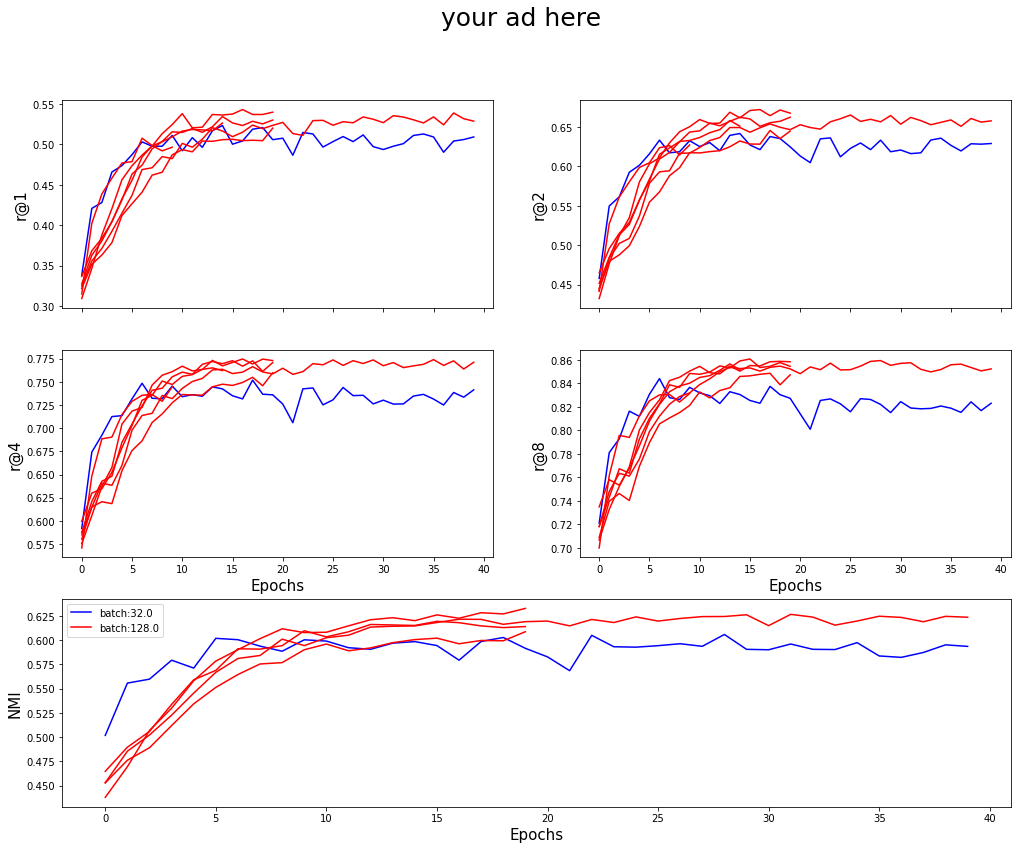

In [14]:
batch_df = cub_df[(cub_df.scl_x ==3) & (cub_df.scl_p == 3) & (cub_df.lr == 1) & 
       (cub_df.batch == 32)]
batch_df1 = cub_df[(cub_df.scl_x ==3) & (cub_df.scl_p == 3) & (cub_df.lr == 1) & 
       (cub_df.batch == 128) & (cub_df['torch version'] == '1.1.0')]
print(batch_df.shape)
print(batch_df1.shape)
plot_df([batch_df,batch_df1], labels = 'batch', colors = ['b','r'])

Here we can see that the model shows wildly varying performance based on the seed used during the training and testing phases 

### 2.3 Impact of learning rate on performance

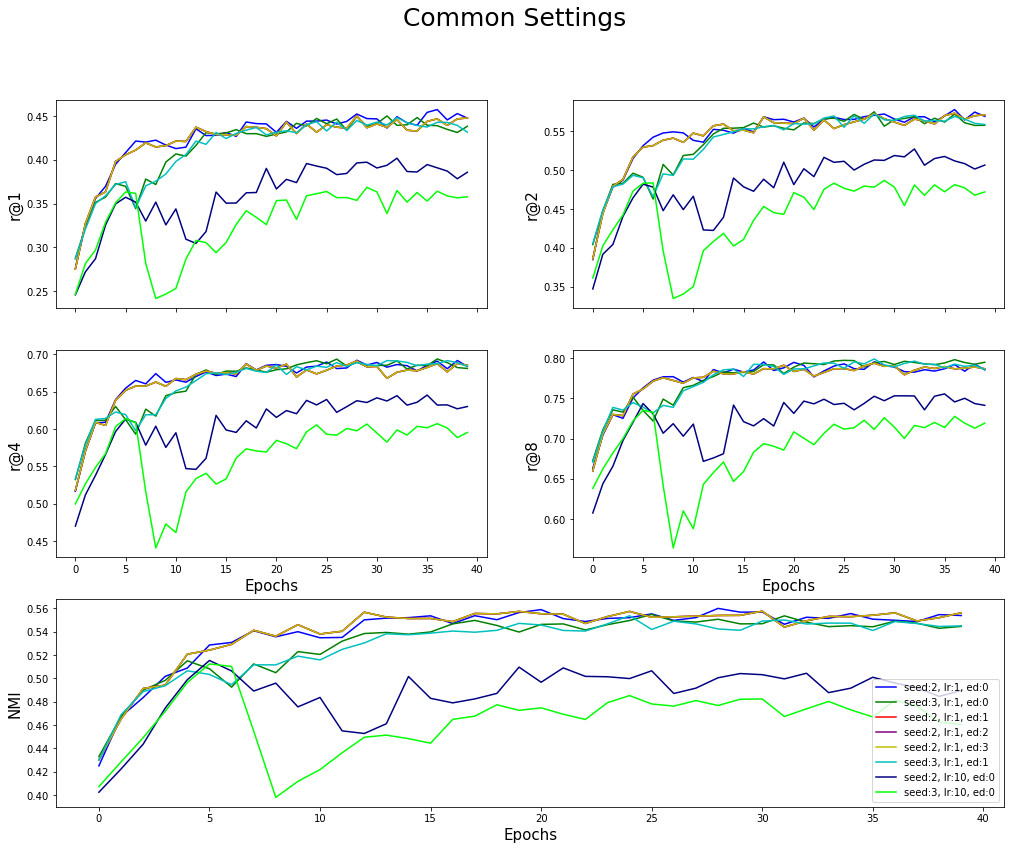

In [7]:
# results_df1 = results_df[(results_df.scl_x == 3) & (results_df.scl_p == 3)]
# results_df1 = results_df[(results_df['index'] == 0) | (results_df['index'] == 4) | (results_df['index'] == 8)]
# results_df1 = results_df
# results_df1 = results_df[(results_df.scl_x == results_df.scl_p) & (results_df.lr==1)]
results_df = cub_df
results_df1 = results_df[(results_df.scl_x == 8) & (results_df.scl_p == 8) & (results_df.lr == 1) ]
results_df1 = results_df1[(results_df1['seed'] > 1) & (results_df1['seed'] < 4)]
results_df2 = results_df[(results_df.scl_x == 8) & (results_df.scl_p == 8) & (results_df.lr == 10)]
results_df2 = results_df2[(results_df2['seed'] > 1) &(results_df2['seed'] < 4)]
plot_df([results_df1, results_df2], labels = ['seed','lr','ed'], title = 'Common Settings' ) 

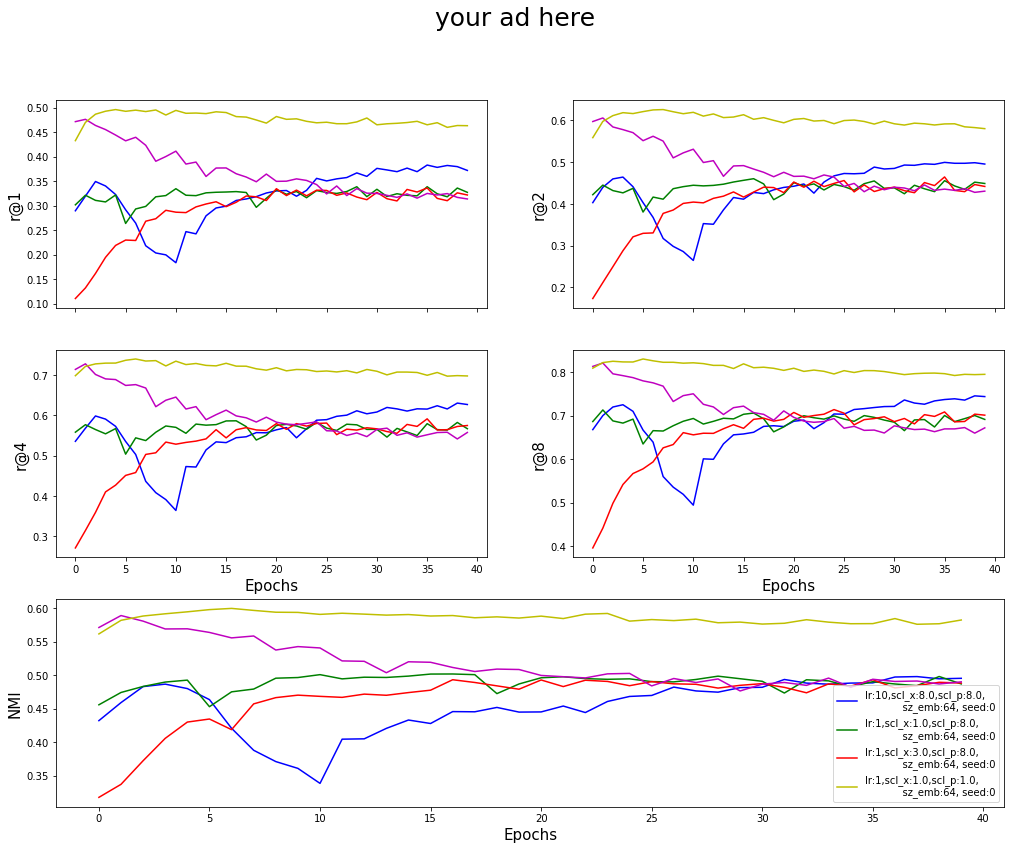

In [8]:
results_df3 = results_df[((results_df.iloc[:,7:-2] == results_df[results_df.edition == 1].
 iloc[1,7:-2]).sum(axis = 1) == 4) & (results_df.seed == 0)]
plot_df(results_df3)

### 2.4 Inconsistencies with Different Pytorch Editions

In [48]:
cub_df[cub_df['torch version'] == '1.6.0']['index'].unique()
cub_df[((cub_df.iloc[:,7:-2] == cub_df[(cub_df['index'] == 51)].iloc[1, 7:-2]).sum(axis = 1) == 6)
        & (cub_df['torch version'] == '1.1.0') & 
       (cub_df.batch == 32)]
# cub_df[(cub_df['torch version'] == '1.1.0') & 


,index,epoch,r@1,r@2,r@4,r@8,NMI,lr,scl_x,scl_p,sz_emb,seed,edition,torch version,batch
1365,57,0,0.471303,0.597400,0.713538,0.813471,0.571097,1,1.0,1.0,64,0,0,1.1.0,32.0
1366,57,1,0.476030,0.606009,0.727380,0.821236,0.588928,1,1.0,1.0,64,0,0,1.1.0,32.0
1367,57,2,0.463538,0.584402,0.701047,0.796421,0.580586,1,1.0,1.0,64,0,0,1.1.0,32.0
1368,57,3,0.455098,0.577988,0.690074,0.792201,0.568919,1,1.0,1.0,64,0,0,1.1.0,32.0
1369,57,4,0.443957,0.570729,0.688386,0.787643,0.569153,1,1.0,1.0,64,0,0,1.1.0,32.0
1370,57,5,0.432140,0.551485,0.673869,0.780216,0.563754,1,1.0,1.0,64,0,0,1.1.0,32.0
1371,57,6,0.439399,0.562120,0.675895,0.775658,0.555607,1,1.0,1.0,64,0,0,1.1.0,32.0
1372,57,7,0.423025,0.550473,0.667454,0.768062,0.558437,1,1.0,1.0,64,0,0,1.1.0,32.0
1373,57,8,0.390446,0.510297,0.621202,0.732782,0.537502,1,1.0,1.0,64,0,0,1.1.0,32.0
1374,57,9,0.400068,0.522282,0.637238,0.746286,0.542616,1,1.0,1.0,64,0,0,1.1.0,32.0


In [56]:
cub_df[cub_df['torch version'] == '1.6.0']

,index,epoch,r@1,r@2,r@4,r@8,NMI,lr,scl_x,scl_p,sz_emb,seed,edition,torch version,batch
1125,51,0,0.332714,0.456955,0.585415,0.719109,0.469580,1,1.0,1.0,64,0,0,1.6.0,128.0
1126,51,1,0.347232,0.474342,0.606853,0.737171,0.477897,1,1.0,1.0,64,0,0,1.6.0,128.0
1127,51,2,0.344868,0.461006,0.601283,0.725186,0.473184,1,1.0,1.0,64,0,0,1.6.0,128.0
1128,51,3,0.344700,0.473498,0.599595,0.721472,0.484595,1,1.0,1.0,64,0,0,1.6.0,128.0
1129,51,4,0.356516,0.481600,0.611074,0.732444,0.497389,1,1.0,1.0,64,0,0,1.6.0,128.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1360,56,35,0.335922,0.464551,0.591155,0.708812,0.493184,1,3.0,8.0,64,0,0,1.6.0,128.0
1361,56,36,0.314652,0.432309,0.563471,0.686023,0.480955,1,3.0,8.0,64,0,0,1.6.0,128.0
1362,56,37,0.309926,0.429271,0.564315,0.686867,0.484438,1,3.0,8.0,64,0,0,1.6.0,128.0
1363,56,38,0.325962,0.446320,0.572248,0.703747,0.489367,1,3.0,8.0,64,0,0,1.6.0,128.0


In [66]:
cub_df[(cub_df['index'] == 56)]

,index,epoch,r@1,r@2,r@4,r@8,NMI,lr,scl_x,scl_p,sz_emb,seed,edition,torch version,batch
1325,56,0,0.110230,0.173025,0.271438,0.396185,0.317741,1,3.0,8.0,64,0,0,1.6.0,128.0
1326,56,1,0.131837,0.211344,0.314652,0.441762,0.337158,1,3.0,8.0,64,0,0,1.6.0,128.0
1327,56,2,0.161377,0.249325,0.359386,0.498818,0.372390,1,3.0,8.0,64,0,0,1.6.0,128.0
1328,56,3,0.194294,0.287643,0.410196,0.542032,0.405767,1,3.0,8.0,64,0,0,1.6.0,128.0
1329,56,4,0.218602,0.320898,0.426907,0.567184,0.430042,1,3.0,8.0,64,0,0,1.6.0,128.0
1330,56,5,0.229575,0.329338,0.451047,0.577988,0.434591,1,3.0,8.0,64,0,0,1.6.0,128.0
1331,56,6,0.228731,0.330351,0.458136,0.594024,0.418732,1,3.0,8.0,64,0,0,1.6.0,128.0
1332,56,7,0.268062,0.377110,0.503038,0.626266,0.457172,1,3.0,8.0,64,0,0,1.6.0,128.0
1333,56,8,0.273126,0.385213,0.507090,0.633862,0.466492,1,3.0,8.0,64,0,0,1.6.0,128.0
1334,56,9,0.290344,0.401080,0.533592,0.661209,0.470188,1,3.0,8.0,64,0,0,1.6.0,128.0


In [10]:
#plot_df(food_df[(food_df['sz_emb'] == 64) & (food_df.lr == 1)])

## 3. Theoretical Background

In this section I will summarize all of the new theoretical background information, I have learned during this challenge

### 3.1 Meta-Learning

* One of the techniques of few-shot and zero-shot learning (haven't found out what the others are)
* "Learning to learn" -> make networks, that quickly adapt to new classes

#### 3.1.1 Metric Learning

* turn data into embeddings: N-dimensional Vectors (typically 64 or 128 dimensions)
* Calculate distance (i.e. Euclidean distance) between embeddings
* Goal:
    * data points from the same class are close
    * data points from different classes are far apart
    * classes form clusters in embedding space

##### 3.1.1.1 Prototypical Networks

* make a prototype embedding for each class
* prototype is the average of all embeddings in the class
* model learns embedding function (neural network) to map examples into embedding space where distance corresponds to semantic similarity
* classify data points based on distances to prototypes
* generalization performance is based on test episodes. Prediction of query inputs into the most likely class

##### 3.1.1.2  Proxy-NCA
* Issues to solve:
    * Sampling sets of informative triplets during training is expensive.
    * Convergence of triplet-based techniques is slow.
* Solution:
    * Represent a set of data points through a proxy, a point close to all
      data points in the set
    * Use the proxies to train the network
* Advantages:
    * faster (less data points)
    * embeddings of proxies can be stored in ram alone
    * much less computation during training because expensive sampling techniques are substituted by just calculating a proxy
    * faster convergence (about 3x according to paper)
    * better scores in zero-shot applications (according to paper)
    
     


* Proxy assignment: Two methods:
    * static assignment:
        * Triplets defined by semantic labels
        * Proxies can be associated with semantic labels
          $P = \{p_1..p_L\}$
        * Datapoint assigned to proxy with its label: $p(x) = p_{c(x)}$
        * Triplets do not need to be sampled
        * Only anchor point x needs to be sampled
        * Other proxies $p_i$, where $i {\ne} x$ are then used as the negatives
        * $L_{NCA}(x,p_{c(x)},p(Z);\theta)$
    * dynamic assignment:
        * Used when no semantic labels are available
        * For point x, closest proxy is assigned
        * $p(x) = \underset{p{\in}P }{\mathrm{argmin}}\ d(x,p)$
        * Other proxies are used as negatives
        
        
        


##### 3.1.1.3  Metrics:
* recall- @ precision @ k:
    * *predicted: data point picked by model
    * *relevant:  data point either has the right semantic ground-truth label or is over threshold picked by user
    1. Use the model to predict from the a query set. order list descending highest confidence
    2. pick the k highest rated items
    * r@k = # of items predicted & relevant @ k / # relevant @ k
    * p@k = # of items predicted & relevant @ k / # predicted @ k
    * range [0,1]: 1 is best
* Normalized Mutual Information (NMI):
    * information shared by variables
    * measure of dependence of variables
    * very computationally expensive
    * gives measure of quality of a clustering
    * due to being normalized, can be used to compare clusterings with different numbers of clusters
    * range [0,1]: 1 is best
* When to use which metric
    * NMI provides estimate of the clustering performance
    * recall- & precision @ k estimate the classification performance


##### 3.1.1.4  Episodic Learning

##### 3.1.1.5 Semi-Supervised Few-shot learning

##### 3.1.1.6 Triplets:
* Triplets consist of 3 parts:
    * an anchor point (x)
    * a set of similar points (Y)
    * a set of dissimilar points (Z)
* Triplet based loss:
    * goal: learn a distance d where: $d(x,Y) \leq d(x,Z)$
    * Advantage over using 2 points: takes into account relative distance between classes

##### 3.1.1.7 Meta-Learning for Semi-Supervised Few-Shot Classification

* Extension to Prototypical Networks (3.1.1.1)
* training set consists of labeled and unlabeled examples (S,R)
* training procedure is analogue to prototypical networks, but instead of using the prototypes $p_i$ in the loss function, refined prototypes $\tilde{p}_i$ are used.
* There are 3 ways of updating the prototypes:
    1) 


### 3.1.2 Optimization-based meta-learning:
* Optimize the meta parameters of a model to converge very fast. Examples are MAML, Reptile and LEO.

## 3.2 Recurrent Neural Nets (RNNs)
* Recurrent Neural Nets. Networks, that have a looping component
* able to combine information from previous datapoints in following predictions
* struggle with long term memory

### 2.1 Long Short Term Memory (LSTM)
* Able to retain information for a longer amount of time through complicated layers
* gates in the neuron will evaluate which information to forget and which new information to remember. This is very closely controlled and it is intentionally hard for the net to change information in the remembered information.

##### 2.1.2 Inception
* Aim:
    * solve issue of solving right kernel size for the convolutions:
        * Information can be distributed very differently:
           close up photo of a dog: you need a large kernel or the dog will be missed
           dog in the background: small kernel or the dog will be missed
    * reduce depth of network:
        * deep networks lead to overfitting & vanishing gradient
        * too many convolutional layers -> computationally expensive
* Solution:
    * have filters with different kernel sizes operate on the same level.
      this makes the network "wider" not "deeper"
    * Different architectures for LSTMs (the proxy model uses inception 2)
    * combine different types of convolutions to make the network "wider" instead of "deeper"
        * This means that during a single layer multiple operations can be completed at the same time
        * Reduces issues with neurons "dying" due to the network being too deep